In this notebook, we will compare the tuned models for: Decision Tree, Extra Tree, Random Forest, Logistic Regression, BernouliNB, AdaBoost, XGBoost and a voting Classifier using extra tree, logistic regression, Berloulli Naive Bayes and XGBoost. 

We will use ROC-AUC score, weighted F-1 score and training time as out main metric to select our final model. We will perform a 5-fold cross validation, and the variance of the ROC-AUC score and weighted F-1 score will be taken into consideration. We will used the averaged fitting and testing time for the cross-validation sets to compare the time efficiency of different algorithms.

In [1]:
## Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import cross_validate

## Import models
## Tree models:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
##Logistic regression:
from sklearn.linear_model import LogisticRegression
## Naive Bayes:
from sklearn.naive_bayes import BernoulliNB
##Boosting models:
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
#Voting method
from sklearn.ensemble import VotingClassifier

from sklearn.base import clone

## Performace metrics for classification algorithms
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

##Timer
import time

In [2]:
## Load data and perform trai-test split:
## Import cleaned CSV (no date information)
cmm_pa_clf_read = pd.read_csv("../Data/cmm_pa_clf.csv",index_col = 0)

## Separate the features from the output
cmm_pa_clf_data = cmm_pa_clf_read.drop(columns = 'pa_approved').copy()
cmm_pa_clf_target = cmm_pa_clf_read['pa_approved'].copy()

## Train-test split
X_train,X_test,y_train,y_test= train_test_split(cmm_pa_clf_data, cmm_pa_clf_target, test_size = 0.2, 
                                             random_state = 10475, shuffle = True,
                                            stratify = cmm_pa_clf_target)
## K-fold validation to analyze the performance of algorithms mentioned above 
kfold = StratifiedKFold(5, shuffle=True, random_state=10475)

## Baseline Model  
Our baseline model will be predicting all claims will have PA approved, as the majority of claims are approved.

## Model comparison 

In [3]:
d_tree = DecisionTreeClassifier(max_depth=8,random_state=10475)
e_tree = ExtraTreesClassifier(n_estimators=50,max_depth=9,random_state=10475)
forest = RandomForestClassifier(n_estimators=25,max_depth=6)
logreg = LogisticRegression(C=.1)
b_nb = BernoulliNB(alpha = 0.1, fit_prior = True)
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=7,algorithm='SAMME.R',
                         learning_rate=1.0)
xgb_clf= xgb.XGBClassifier(booster = 'gbtree',objective = 'binary:logistic',max_depth = 3,subsample = 1,
                           tree_method = 'approx', n_estimators= 90,
                           eta = 1, use_label_encoder=False, eval_metric = 'auc')
logreg_clone = clone(logreg)
e_tree_clone = clone(e_tree)
b_nb_clone = clone(b_nb)
xgb_clf_clone = clone(xgb_clf)
voting = VotingClassifier([('logreg', logreg_clone),
                          ('extrat', e_tree_clone),
                          ('bnb', b_nb_clone),
                          ('xgbc', xgb_clf_clone)],
                          voting='soft')


In [4]:
d_tree_cv = cross_validate(d_tree, X_train, y_train, cv=kfold,scoring = ['accuracy','roc_auc','f1_weighted'])
e_tree_cv = cross_validate(e_tree, X_train, y_train, cv=kfold,scoring = ['accuracy','roc_auc','f1_weighted'])
forest_cv = cross_validate(forest, X_train, y_train, cv=kfold,scoring = ['accuracy','roc_auc','f1_weighted'])
logreg_cv = cross_validate(logreg, X_train, y_train, cv=kfold,scoring = ['accuracy','roc_auc','f1_weighted'])
b_nb_cv = cross_validate(b_nb, X_train, y_train, cv=kfold,scoring = ['accuracy','roc_auc','f1_weighted'])
ada_cv = cross_validate(ada, X_train, y_train, cv=kfold,scoring = ['accuracy','roc_auc','f1_weighted'])
xgb_clf_cv = cross_validate(xgb_clf, X_train, y_train, cv=kfold,scoring = ['accuracy','roc_auc','f1_weighted'])
voting_cv = cross_validate(voting, X_train, y_train, cv=kfold,scoring = ['accuracy','roc_auc','f1_weighted'])

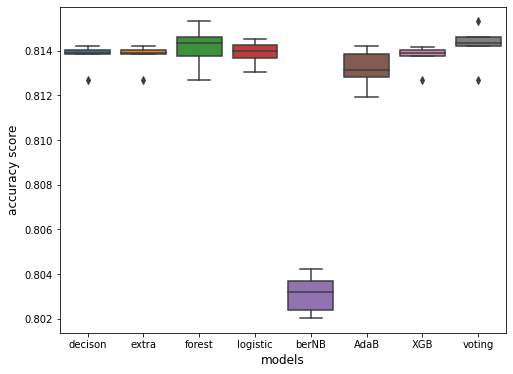

In [5]:
acc_score = [d_tree_cv['test_accuracy'],e_tree_cv['test_accuracy'],
             forest_cv['test_accuracy'],logreg_cv['test_accuracy'],
             b_nb_cv['test_accuracy'],ada_cv['test_accuracy']
            ,xgb_clf_cv['test_accuracy'],voting_cv['test_accuracy']]
plt.figure(figsize=(8,6))
sns.boxplot(data=acc_score)
plt.xticks(range(0,8),['decison','extra','forest',
                       'logistic','berNB','AdaB','XGB','voting'], fontsize=10)
plt.xlabel('models',fontsize=12)
plt.ylabel('accuracy score',fontsize=12)
plt.show()

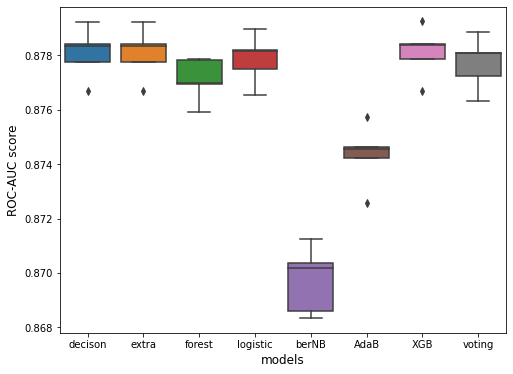

In [6]:
acc_score = [d_tree_cv['test_roc_auc'],e_tree_cv['test_roc_auc'],
             forest_cv['test_roc_auc'],logreg_cv['test_roc_auc'],
             b_nb_cv['test_roc_auc'],ada_cv['test_roc_auc']
            ,xgb_clf_cv['test_roc_auc'],voting_cv['test_roc_auc']]
plt.figure(figsize=(8,6))
sns.boxplot(data=acc_score)
plt.xticks(range(0,8),['decison','extra','forest',
                       'logistic','berNB','AdaB','XGB','voting'], fontsize=10)
plt.xlabel('models',fontsize=12)
plt.ylabel('ROC-AUC score',fontsize=12)
plt.show()

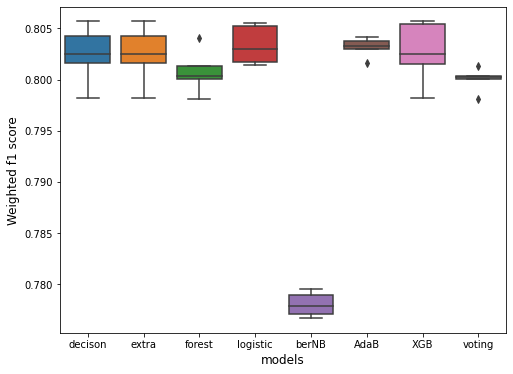

In [7]:
acc_score = [d_tree_cv['test_f1_weighted'],e_tree_cv['test_f1_weighted'],
             forest_cv['test_f1_weighted'],logreg_cv['test_f1_weighted'],
             b_nb_cv['test_f1_weighted'],ada_cv['test_f1_weighted']
            ,xgb_clf_cv['test_f1_weighted'],voting_cv['test_f1_weighted']]
plt.figure(figsize=(8,6))
sns.boxplot(data=acc_score)
plt.xticks(range(0,8),['decison','extra','forest',
                       'logistic','berNB','AdaB','XGB','voting'], fontsize=10)
plt.xlabel('models',fontsize=12)
plt.ylabel('Weighted f1 score',fontsize=12)
plt.show()

Based on the plots above, we observe that the performance of decision tree, extra tree,logistic regression and XGBoost models have similar performance on the three scales we choose. 

Bernoulli Naive Bays is out-performed by all other models for all metrics, and AdaBoosting is out-performed for ROC-AUC scores.  Random forest and voting method have slightly lower weighted f1 score. 

Now our competiters are decision tree, extra tree,random forest, logistic regression, GBoost and voting.

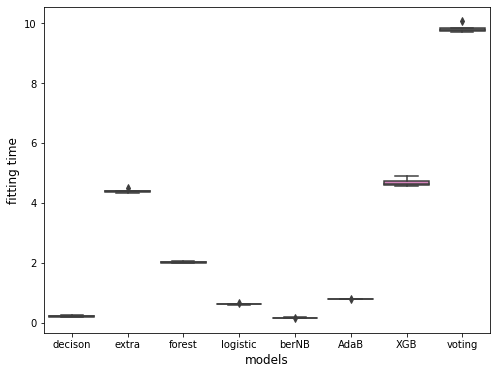

In [8]:
acc_score = [d_tree_cv['fit_time'],e_tree_cv['fit_time'],
             forest_cv['fit_time'],logreg_cv['fit_time'],
             b_nb_cv['fit_time'],ada_cv['fit_time']
            ,xgb_clf_cv['fit_time'],voting_cv['fit_time']]
plt.figure(figsize=(8,6))
sns.boxplot(data=acc_score)
plt.xticks(range(0,8),['decison','extra','forest',
                       'logistic','berNB','AdaB','XGB','voting'], fontsize=10)
plt.xlabel('models',fontsize=12)
plt.ylabel('fitting time',fontsize=12)
plt.show()

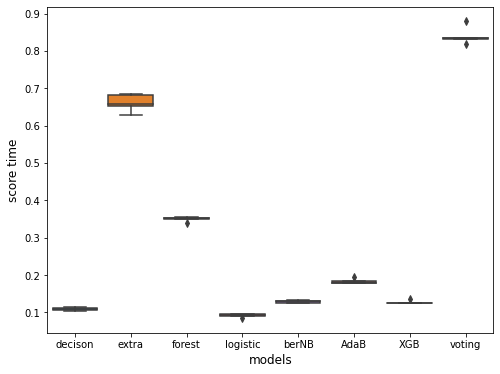

In [9]:
acc_score = [d_tree_cv['score_time'],e_tree_cv['score_time'],
             forest_cv['score_time'],logreg_cv['score_time'],
             b_nb_cv['score_time'],ada_cv['score_time']
            ,xgb_clf_cv['score_time'],voting_cv['score_time']]
plt.figure(figsize=(8,6))
sns.boxplot(data=acc_score)
plt.xticks(range(0,8),['decison','extra','forest',
                       'logistic','berNB','AdaB','XGB','voting'], fontsize=10)
plt.xlabel('models',fontsize=12)
plt.ylabel('score time',fontsize=12)
plt.show()

Extra Tree, random forest, XGBoost and voting methods have the longer training (fitting) time, and their performance are not significantly better. We would like to pick from logistic regression and decision tree. 

Since we only have two models left, we can compare their performance on the training set, and we will fit our data using the entire training set.

In [10]:
def column(matrix, i):
    return [row[i] for row in matrix]

d_tree_f = DecisionTreeClassifier(max_depth=8,random_state=10475)
logreg_f = LogisticRegression(C=.1)
d_tree_f.fit(X_train,y_train)
logreg_f.fit(X_train,y_train)
d_pred = d_tree_f.predict(X_test)
log_pred = logreg_f.predict(X_test)
d_pred_prob = d_tree_f.predict_proba(X_test)
log_pred_prob = logreg_f.predict_proba(X_test)

print('Classification report for decision tree')
print(classification_report(y_test, d_pred))
print('Accuacy score for decision tree is: ', accuracy_score(y_test, d_pred),'\n')
d_pred_prob = column(d_pred_prob,1)
print('ROC-AUC score for decision tree is: ', roc_auc_score(y_test, d_pred_prob),'\n')

print('Classification report for logistic regression')
print(classification_report(y_test, log_pred))
print('Accuacy score for logistic regression is: ', accuracy_score(y_test, log_pred),'\n')
log_pred_prob = column(log_pred_prob,1)
print('ROC-AUC score for logistic regression is: ', roc_auc_score(y_test, log_pred_prob),'\n')

Classification report for decision tree
              precision    recall  f1-score   support

         0.0       0.73      0.48      0.58     29527
         1.0       0.83      0.94      0.88     81664

    accuracy                           0.81    111191
   macro avg       0.78      0.71      0.73    111191
weighted avg       0.80      0.81      0.80    111191

Accuacy score for decision tree is:  0.8141216465361405 

ROC-AUC score for decision tree is:  0.8787376613995528 

Classification report for logistic regression
              precision    recall  f1-score   support

         0.0       0.69      0.53      0.60     29527
         1.0       0.84      0.92      0.88     81664

    accuracy                           0.81    111191
   macro avg       0.77      0.72      0.74    111191
weighted avg       0.80      0.81      0.80    111191

Accuacy score for logistic regression is:  0.8134291444451439 

ROC-AUC score for logistic regression is:  0.8782991315188728 



The overall performance of decision tree is slightly better than logistic regression, decision tree is our final model.